In [28]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import nltk
nltk.download('stopwords')

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define utility methods to run/evaluate the model -

In [29]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def eval_metric(model, history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]
  e = range(1, NB_START_EPOCHS + 1)
  plt.plot(e, metric, 'bo', label='Train ' + metric_name)
  plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
  plt.legend()
  plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
  results = model.evaluate(X_test, y_test)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results

def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 

def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
  metric_model_1 = model_hist_1.history[metric]
  metric_model_2 = model_hist_2.history[metric]
  e = range(1, NB_START_EPOCHS + 1)
  
  metrics_dict = {
      'acc' : 'Training Accuracy',
      'loss' : 'Training Loss',
      'val_acc' : 'Validation accuracy',
      'val_loss' : 'Validation loss'
  }
  
  metric_label = metrics_dict[metric]
  plt.plot(e, metric_model_1, 'bo', label=model_1.name)
  plt.plot(e, metric_model_2, 'b', label=model_2.name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_label)
  plt.title('Comparing ' + metric_label + ' between models')
  plt.legend()
  plt.show()

def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss']) + 1
  print("Minimum validation loss reached in epoch {}".format(min_epoch))
  return min_epoch

### Read and prepare dataset -

In [30]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/SureStartTrainingData/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

# Remove stop words
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

# Split dataset into training/testing 
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

# Tokenize the words in the dataset
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

# Convert target classes with one-hot encoding
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

# Make validation set
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

### Define the model and run/evaluate it -

Minimum validation loss reached in epoch 3


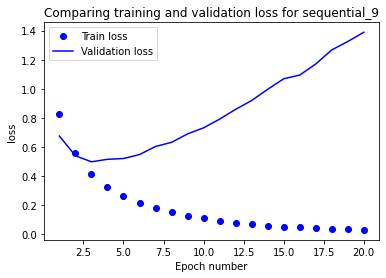

Minimum validation loss reached in epoch 13


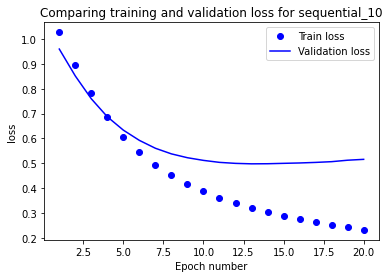

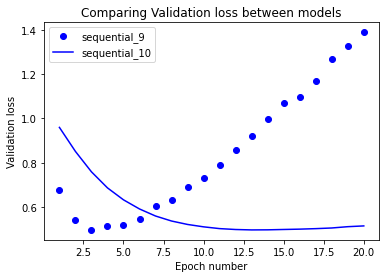

Minimum validation loss reached in epoch 3


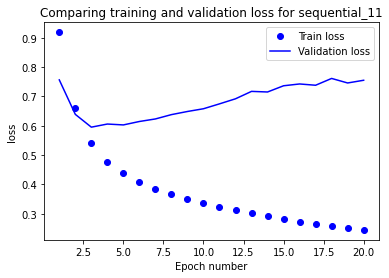

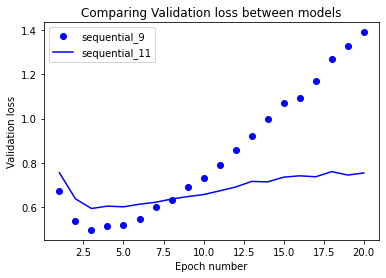

Minimum validation loss reached in epoch 7


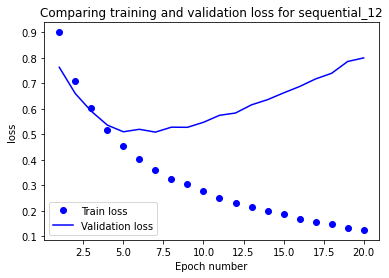

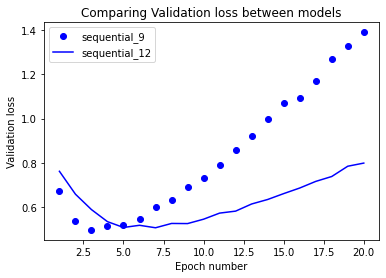

In [31]:
# Baseline model with high overfitting -
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

# Reduced model - (removed 1 Dense layer, and reduced element count in the Dense layer to 16)
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')


# L2 Regularized model - (Two 64 element count Dense layers with l2 regularization)
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'loss')

compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

# Drop-out layered model - (Added DropOut layers between Dense layers)
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

### Evaluate the testing data -

In [32]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 2ms/step - loss: 1.1543 - accuracy: 0.7486

Test accuracy: 74.86%
46/46 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.7896

Test accuracy: 78.96%
46/46 [==============================] - 0s 3ms/step - loss: 0.7889 - accuracy: 0.7801

Test accuracy: 78.01%
46/46 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.7801

Test accuracy: 78.01%
